# Plasma Width from Different Bessel Beams

In [1]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
from ionization import ionization
from lens import profile
from lens import design
import matplotlib.pyplot as plt
plt.style.use('notes')
%load_ext autoreload
%autoreload 2

path = '/mnt/md0/Data/rariniello/Lithium_Oven/Plasma_Width/'
lam = 0.796
# All length units are in um

Examine the different transverse plasma profiles that result from changing the width of the central Bessel. The plasma width results from an interplay between the Bessel width and refraction. Very narrow Bessel functions have high angle converging rays and narrow focal spots. Subsequently, the rays don't traverse very much plasma before reaching the focus and don't experience significant refraction. As the central Bessel spot gets wider, the plasma gets wider and the rays become shallower. As a result, the laser propagates through more plasma, deflecting the rays outward, and resulting in an even wider plasma.

The net result is that widening the Bessel focus can result in a significantly wider plasma than one might expect. Of course everything isn't so simple. At some point the rays pass through so much plasma before they reach the focus that the high intensity focal spot never forms. In this case the gas is never fully ionized and a very wide partially ionized plasma forms.

In this notebook I examine how the Bessel beam width, defined as the distance between the zeroes of the Bessel function, effects the width and peak ionization of the plasma.

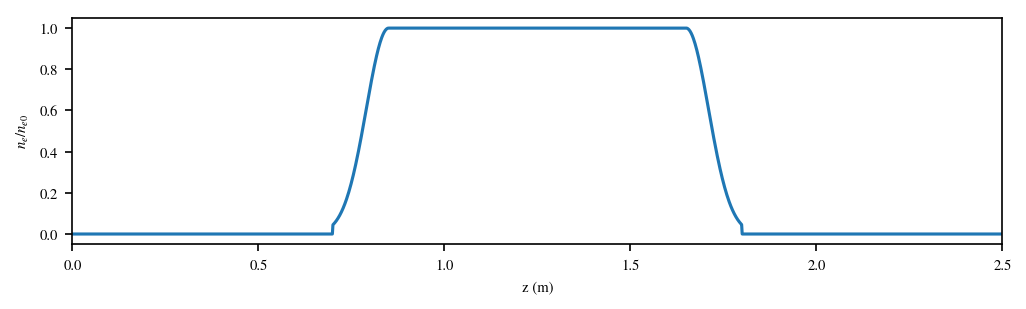

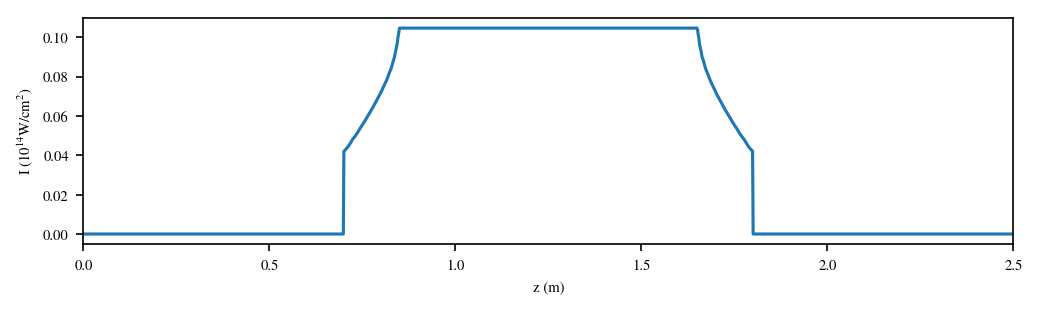

Plasma starts at 0.32m and ends at 2.25m


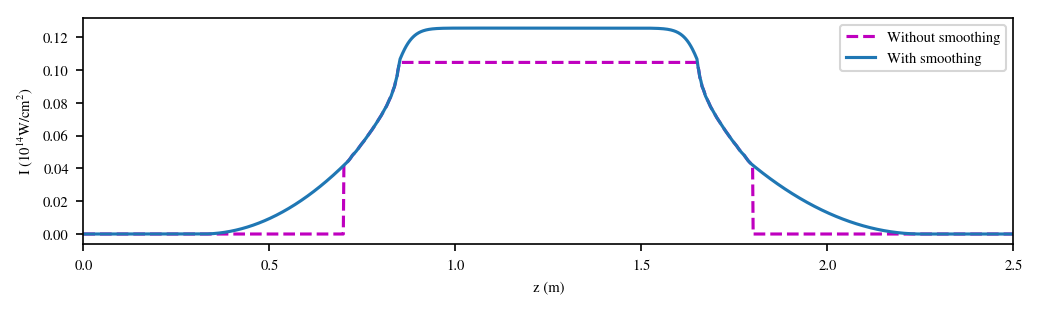

In [2]:
length = 80e4
Nz = 2**16
Z = 100e6
z0 = 0.85e6
xlim = [0, 2.5]
tau = 30 # RMS pulse length in fs
ion = {'atom' : ionization.Li,
       'tau' : tau,
       'type' : 'gaussian'}
z, I_la = profile.cutoff_gaussian_intensity(Nz, Z, z0, length, 15e4, 6e4, 15e4, 6e4, ion, 8, 0.4, path, xlim)

A slightly ramping density profile tends to improve the performance of the optic. There is a minimum intensity required to reach the peak ionization fraction for a given Bessel. Increasing the intensity beyond this results in a wider plasma, but it doesn't increase the maximum ionization fracion. Based on experience, the target intensity should be about 4 times the threshold for ionization.

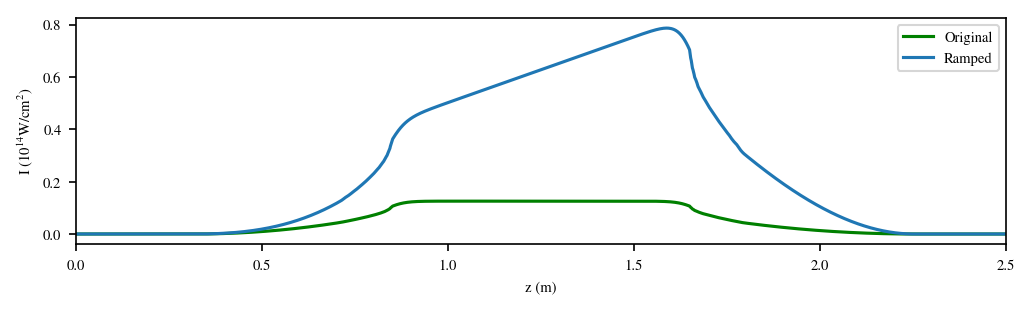

In [3]:
# Add a ramped intensity profile
I_ramped = abs(4*I_la*(1e-6*(z-1e6)+1))
plt.figure(figsize=(8, 2), dpi=150)
plt.plot(z/1e6, I_la, 'g')
plt.plot(z/1e6, I_ramped)
plt.legend(['Original', 'Ramped'])
plt.xlabel(r'z (m)')
plt.ylabel(r'I ($\mathrm{10^{14}W/cm^2}$)')
plt.xlim(xlim)
plt.show()

In [4]:
# Create the gas density the laser is going into
ne0 = 3.5e16/1e17
start, n_plot, n = profile.lithium_oven_profile(z, 1.25e6, ne0)

In [5]:
roots = np.array([60, 65, 70, 75, 80, 85, 90, 95, 100])
# I figured all the widths out earlier using the domain test function and removed them from the notebook
X_a = np.array([12e3, 11e3, 10e3, 10e3, 10e3, 9e3, 9e3, 8e3, 8e3])
N = len(roots)
Z = 80e4
Nz = 400
Nx_r = 2**10
ne = np.zeros((N, Nz, Nx_r), dtype='double')
x = np.zeros((N, Nx_r), dtype='double')

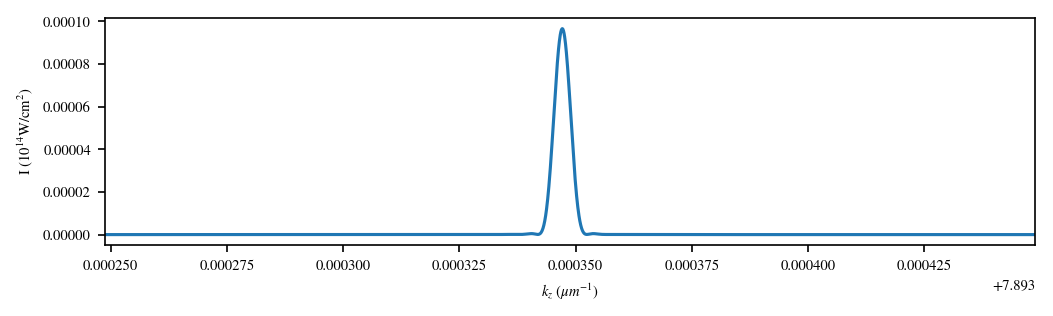

In [ ]:
for i in range(N):
    r, E = design.calculate_tran_field(z, I_ramped, 20e3, roots[i], lam, path, 20e-5, xlim, [0, 12])
    X = 25e3
    Nx = 2**13
    beam0, pulseParams = design.propagate_to_start(r, E, start, X, Nx, path, lam, tau, 20, [-1, 1])
    pulse, I, ne[i, :, :] = design.plasma_refraction(X_a[i], Nx_r, Z, Nz, beam0, pulseParams, ionization.Li, n, start, 1)
    x[i, :] = pulse.x
    ext = [0, Z/1e4, -X_a[i]/2, X_a[i]/2]
    np.save(path+'ne_%d.npy' % roots[i], ne[i, :, :])
    design.plot_plasma_density(pulse, ne[i, :, :], ne0, ext, lines=[20, 40, 60], name=path+'ne_%d.npy' % roots[i])

The three plots below show transverse lineouts of the various plasmas created as well as the variation in width and peak plasma density as a function of Bessel width. Useful for designing as wide a plasma source as possible with full ionization.

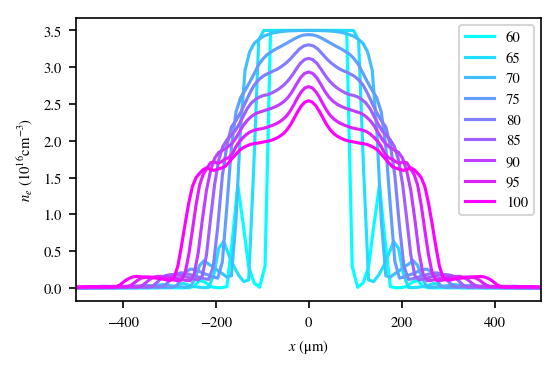

In [7]:
fig = plt.figure(figsize=(4, 2.5), dpi=150)
colors = [plt.cm.cool(i) for i in np.linspace(0, 1, 9)]
ax = plt.subplot()
ax.set_prop_cycle('color', colors)
for i in range(N):
    plt.plot(x[i, :], ne[i, int(Nz/2), :]/1e16, label='%d' % roots[i])
plt.xlim(-500, 500)
plt.xlabel(r'$x$ ($\mathrm{\mu m}$)')
plt.ylabel(r'$n_e$ ($10^{16}\mathrm{cm^{-3}}$)')
plt.legend()
plt.show()

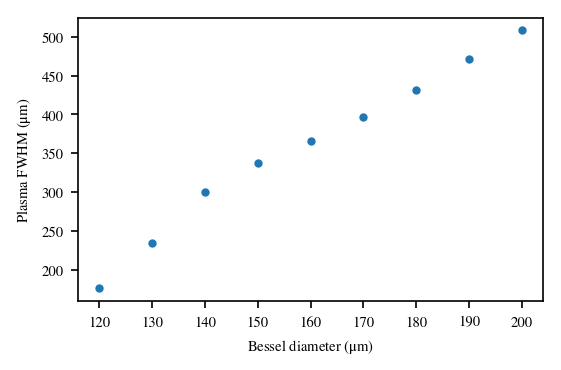

In [20]:
from scipy.interpolate import UnivariateSpline
def fwhm(x, y):
    spline = UnivariateSpline(x, y-np.max(y)/2, s=0)
    r1, r2 = spline.roots()
    return abs(r2-r1)

widths = np.zeros(N)
for i in range(N):
    widths[i] = fwhm(x[i, :], ne[i, int(Nz/2), :])

fig = plt.figure(figsize=(4, 2.5), dpi=150)
plt.plot(2*roots, widths, '.')
plt.xlabel(r'Bessel diameter ($\mathrm{\mu m}$)')
plt.ylabel(r'Plasma FWHM ($\mathrm{\mu m}$)')
plt.show()

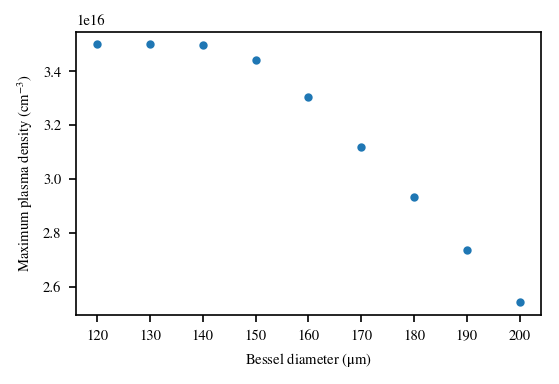

In [9]:
density = np.zeros(N)
for i in range(N):
    density[i] = np.amax(ne[i, int(Nz/2), :])

fig = plt.figure(figsize=(4, 2.5), dpi=150)
plt.plot(2*roots, density, '.')
plt.xlabel(r'Bessel diameter ($\mathrm{\mu m}$)')
plt.ylabel(r'Maximum plasma density ($\mathrm{cm^{-3}}$)')
plt.show()

The Bessel diameter is the most important degree of freedom controlling the width, but the laser intesnity also has an effect. To see how large this effect is, the same calculations are repeated with twice the laser energy.

In [10]:
ne_2 = np.zeros((N, Nz, Nx_r), dtype='double')
x_2 = np.zeros((N, Nx_r), dtype='double')

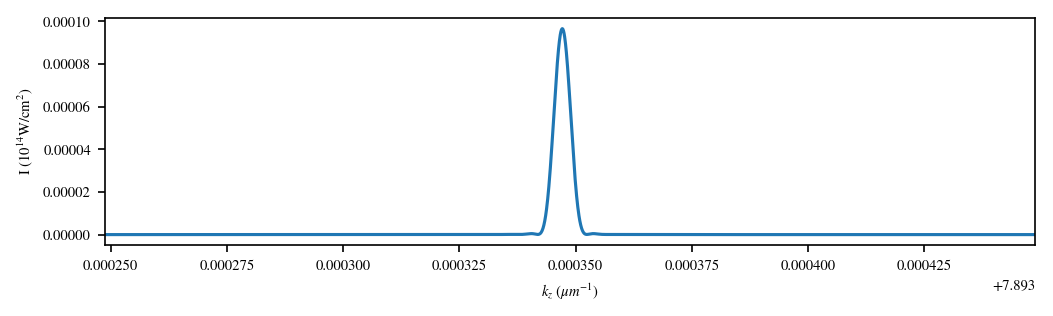

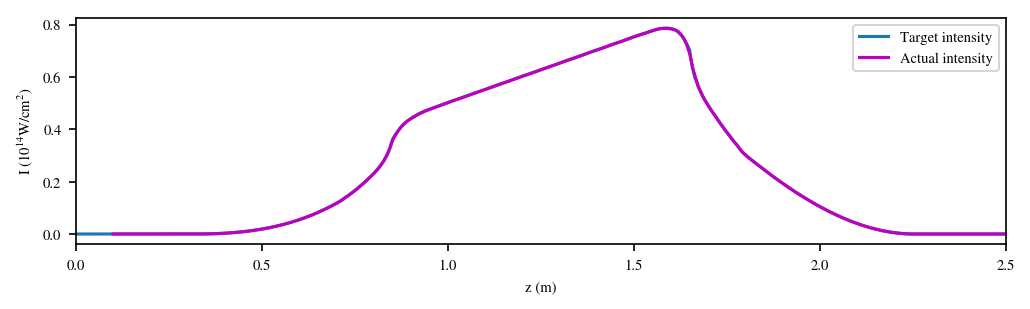

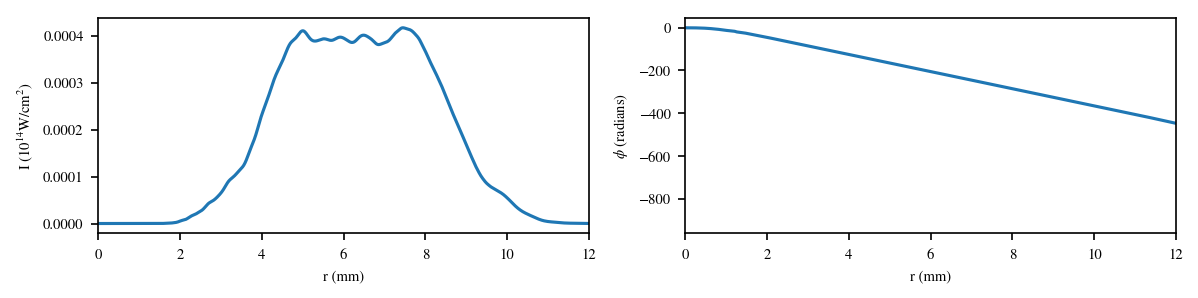

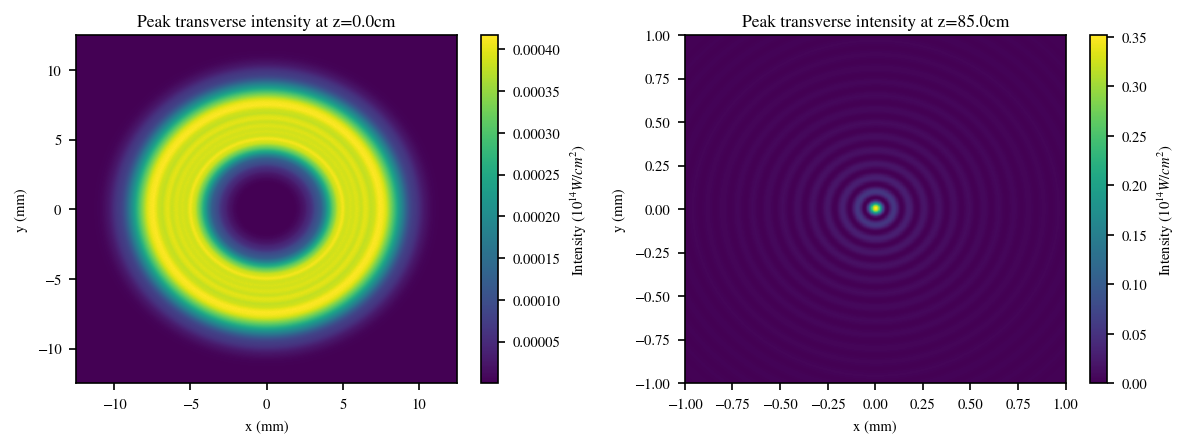

In [ ]:
for i in range(N):
    r, E = design.calculate_tran_field(z, I_ramped, 20e3, roots[i], lam, path, 20e-5, xlim, [0, 12])
    X = 25e3
    Nx = 2**13
    beam0, pulseParams = design.propagate_to_start(r, E, start, X, Nx, path, lam, tau, 20, [-1, 1])
    pulse, I, ne_2[i, :, :] = design.plasma_refraction(X_a[i], Nx_r, Z, Nz, beam0, pulseParams, ionization.Li, n, start, 2)
    x_2[i, :] = pulse.x
    ext = [0, Z/1e4, -X_a[i]/2, X_a[i]/2]
    np.save(path+'ne_%d_2.npy' % roots[i], ne_2[i, :, :])
    design.plot_plasma_density(pulse, ne_2[i, :, :], ne0, ext, lines=[20, 40, 60], name=path+'ne_%d_2' % roots[i])

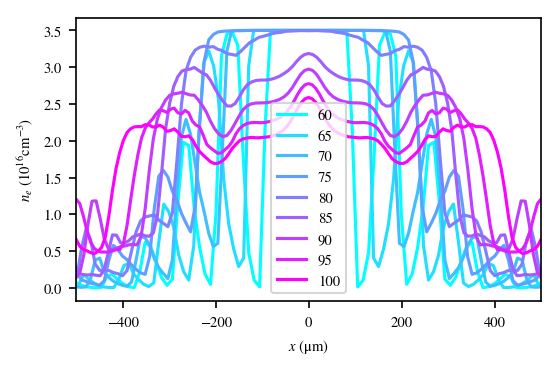

In [12]:
fig = plt.figure(figsize=(4, 2.5), dpi=150)
colors = [plt.cm.cool(i) for i in np.linspace(0, 1, 9)]
ax = plt.subplot()
ax.set_prop_cycle('color', colors)
for i in range(N):
    plt.plot(x_2[i, :], ne_2[i, int(Nz/2), :]/1e16, label='%d' % roots[i])
plt.xlim(-500, 500)
plt.xlabel(r'$x$ ($\mathrm{\mu m}$)')
plt.ylabel(r'$n_e$ ($10^{16}\mathrm{cm^{-3}}$)')
plt.legend()
plt.show()

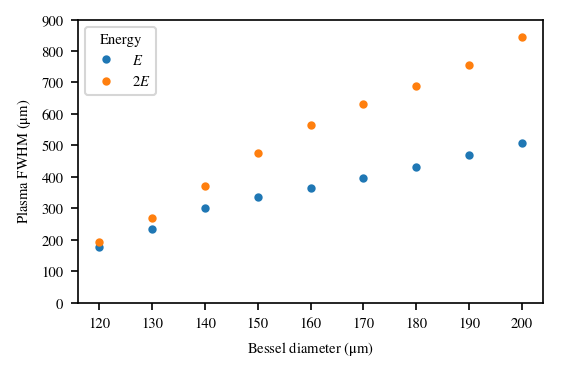

In [23]:
from scipy.interpolate import UnivariateSpline
def fwhm(x, y):
    spline = UnivariateSpline(x, y-np.max(y)/2, s=0)
    r = spline.roots()
    M = len(r)
    return abs(r[int(M/2)]-r[int(M/2)-1])

widths_2 = np.zeros(N)
for i in range(N):
    widths_2[i] = fwhm(x_2[i, :], ne_2[i, int(Nz/2), :])

fig = plt.figure(figsize=(4, 2.5), dpi=150)
plt.plot(2*roots, widths, '.', label=r'$E$')
plt.plot(2*roots, widths_2, '.', label=r'$2E$')
plt.xlabel(r'Bessel diameter ($\mathrm{\mu m}$)')
plt.ylabel(r'Plasma FWHM ($\mathrm{\mu m}$)')
plt.legend(title='Energy')
plt.ylim(0, 900)
plt.show()

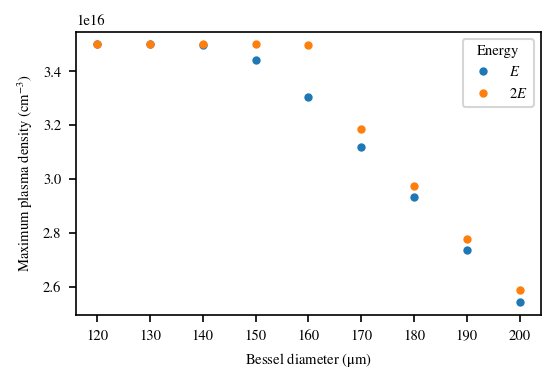

In [24]:
density_2 = np.zeros(N)
for i in range(N):
    density_2[i] = np.amax(ne_2[i, int(Nz/2), :])

fig = plt.figure(figsize=(4, 2.5), dpi=150)
plt.plot(2*roots, density, '.', label=r'$E$')
plt.plot(2*roots, density_2, '.', label=r'$2E$')
plt.xlabel(r'Bessel diameter ($\mathrm{\mu m}$)')
plt.ylabel(r'Maximum plasma density ($\mathrm{cm^{-3}}$)')
plt.legend(title='Energy')
plt.show()